# Topology inconsistencies in NHDPlusV21 Waterbodies

* _The script used to find the lakes which are discussed in this topology check is [here](https://github.com/debboutr/AdjacentBoundaryTool) and takes ~15 min. to run._

__This notebook visits some of the problems in the NHD waterbodies across CONUS. There are 1200 instances downloadable [here](https://www.dropbox.com/sh/n1o3qk7cul784qi/AAClmKyGkExu2pof7IU_83Psa?dl=1) as a shapefile of points that identify where lake polygons have adjacent or overlapping boundaries and have the same FTYPEs.__


In [1]:
import folium
import pandas as pd
import geopandas as gpd
#import matplotlib.pyplot as plt
#from IPython.display import HTML
from shapely.geometry.polygon import Polygon
#% matplotlib inline

### Some lakes duplicated across different VPUs!  -- table shows COMID and Hydroregion
-- __2065__ lakes w/in each zone lie physically outside the boundary of it's respective hydro-region

In [2]:
dups = gpd.read_file('D:/Projects/LakeCat/offnet_LakeCat_framework/off-network.shp')

In [3]:
masters = dups.ix[dups.VPU_orig != dups.VPU_moved]
frog = masters[[u'COMID',u'VPU_orig', 'VPU_moved']].set_index('COMID')
frog.columns = ['Hydroregion', 'Exists_in Hydroregion']
frog.sort_values(by=['Hydroregion','Exists_in Hydroregion'],inplace=True)
frog.head(10)

,Hydroregion,Exists_in Hydroregion
COMID,,
4599707,02,01
22290881,02,01
22290883,02,01
22290885,02,01
6210456,02,01
6223994,02,01
6224902,02,01
9888828,02,03N
8606359,02,03N


In [3]:
dups[dups.duplicated('COMID')]
olap = dups[dups.COMID == 13871500].ix[[3048,3047]]
olap = olap[[u'AREASQKM',u'COMID',u'FTYPE',u'VPU_orig','geometry']]
olap.columns = ['AREASQKM',u'COMID',u'FTYPE',u'VPU','geometry']

#fig, ax = plt.subplots(1, figsize=(3,3))
#olap.plot(ax=ax, color='blue')
#ax.axis('off')
#ax.set_title("Plot of Overlapping lakes from different zones")

In [131]:
ppts = gpd.read_file('./weirdLakeBoundaries.shp')

poi = ppts.ix[ppts.comid1.isin([10683452,1196534,10683452,10683450,1197972,1196534])]

xpts = []
ypts = []
for index, row in poi.iterrows():
    xpts.append([pt.x for pt in row.geometry])
    ypts.append([pt.y for pt in row.geometry])

ifaces = ['LakePond/LakePond' for dd in range(poi['#points'].sum())]

In [155]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
    )
from bokeh.resources import CDN
from bokeh.embed import file_html

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"
source = ColumnDataSource(data={
    'x' : xlist,
    'y' : ylist,
    'com' : tt.ComID.tolist(),
    'FTYPE' : tt.FTYPE.tolist(),
    'idx' : ['#a1dab4', '#404387', '#29788E', '#22A784', '#79D151', '#6b6ecf', '#29788E']
})
p = figure(title="Adjacent Lake Boundaries -- These all have FTYPE = 'LakePond'", tools=TOOLS)

p.patches('x', 'y', line_color="black", fill_color='idx', source=source)

source2 = ColumnDataSource(data={
    'xp' : [item for sublist in xpts for item in sublist],
    'yp' : [item for sublist in ypts for item in sublist],
    'com' : ['This Point exists in both Lake boundaries!' for r in range(219)],
    'FTYPE' : ifaces    
})
p.circle_x(x='xp', y='yp', size=4, source=source2,
                  color="#DD1C77", fill_alpha=0.2, line_width=2)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("COMID", "@com"),
    ("FTYPE", "@FTYPE"),
    ("(Long, Lat)", "($x, $y)"),
]

#show(p)

html = file_html(p, CDN,"Calapooia_PolyCats")
with open("adj_bokeh.html", "w") as text_file:
    text_file.write(html)

### Below shows a number of lakes in hydroregion 16 that share boundaries but are all of FTYPE LakePond
-- The tools on the right side of the figure can be used to zoom and scroll through the window

-- Popups show the COMID and FTYPE of the Lake

-- The red points address topological errors with lake boundaries

In [156]:
from IPython.display import HTML
HTML("./adj_bokeh.html")

In [10]:
wbs = gpd.read_file('D:/NHDPlusV21/NHDPlusGB/NHDPlus16/NHDSnapshot/Hydrography/NHDWaterbody.shp')

In [88]:
tt = wbs[wbs.ComID.isin([1196534,10683450,10683452,10683454,1197972,10683442,10683444])]

In [96]:
tt = tt.ix[[2069,1843,1991,1990,1989,2090,2079]]

In [97]:
xlist = []
ylist = []
for index, row in tt.iterrows():
    #print type(row.geometry)
    if type(row.geometry) == type(Polygon()):
        xls, yls = row.geometry.exterior.coords.xy
        xlist.append(xls.tolist())
        ylist.append(yls.tolist())
    else:
        poly = []
        for pol in row.geometry:
            poly.append(pol)
        for bnd in range(len(poly)):
            xls, yls = poly[bnd].exterior.coords.xy
            xlist.append(xls.tolist())
            ylist.append(yls.tolist())  

In [ ]:
bkhDF = pd.DataFrame()
for index, row in olap.iterrows():
    #print type(row.geometry)
    add = olap.ix[olap.uni == index]
    if type(row.geometry) == type(Polygon()):
        xls, yls = row.geometry.exterior.coords.xy
        j = [index for y in xls]
        coords = pd.DataFrame({'x_coords': xls.tolist(),
                               'y_coords': yls.tolist()},index=j)
    else:
        poly = []
        coords = pd.DataFrame()
        for pol in row.geometry:
            poly.append(pol)
        for bnd in range(len(poly)):
            xls, yls = poly[bnd].exterior.coords.xy
            j = [index for y in xls]
            addOn = pd.DataFrame({'x_coords': xls.tolist(),
                                  'y_coords': yls.tolist()},index=j)
            coords = pd.concat([addOn,coords])
    out = pd.merge(coords,add,how='left',left_index=True,right_index=True)
    bkhDF = pd.concat([bkhDF,out])

### Quad Boundary Splits

In [35]:
trimPts = gpd.read_file('./weirdObj.shp')
f_map=folium.Map(location=[40.925463, -122.720763],zoom_start=11,tiles="Stamen Terrain", control_scale=True, crs='EPSG3857')

fg=folium.FeatureGroup(name="Problem Lake Points")
for geom,com1,com2,vpu in zip(trimPts.geometry,trimPts['comid1'],trimPts['comid2'],trimPts['VPU']):
    lat,lon =  geom.y, geom.x    
    fg.add_child(folium.CircleMarker(location=[lat,lon],
                                     popup= "I'm touching two NHD Waterbodies!",
                                     radius=74,
                                     fill_color="red",
                                     color="darkblue",
                                     fill_opacity=888))
f_map.add_child(fg)
f_map.add_child(folium.GeoJson(data=open('./nbLk_8265748.json'),
                name='Lake COMID 8265748',
                style_function=lambda x: {'fillColor':'blue',
                                          'fill_opacity': 0.74,
                                          'color':'orange'}))
f_map.add_child(folium.GeoJson(data=open('./nbLk_8265752.json'),
                name='Lake COMID 8265752',
                style_function=lambda x: {'fillColor':'blue',
                                          'fill_opacity': 0.74,
                                          'color':'pink'}))
f_map.add_child(folium.GeoJson(data=open('./nbLk_8265754.json'),
                name='Lake COMID 8265754',
                style_function=lambda x: {'fillColor':'blue',
                                          'fill_opacity': 0.74,
                                          'color':'purple'}))
f_map.add_child(folium.GeoJson(data=open('./nbLk_8245358.json'),
                name='Lake COMID 8245358',
                style_function=lambda x: {'fillColor':'blue',
                                          'fill_opacity': 0.74,
                                          'color':'lime'})) 
f_map.add_child(folium.LayerControl())    

__The 4 Waterbodies above can be toggled on and off with the layer control button in the upper right-hand corner of the map above. The COMID for each is listed there as well. The image below shows the quad line boundary intersecting where these polygons are split up. This is pretty common among the waterbodies found in this QA check and is problematic when trying to deliver watershed statistics for each waterbody. Not that we can't build the watershed, but to explain the distinction between these polygons would be tough.__

__[Here](http://debboutr.github.io/lakes.html) is webpage with ALL of the problem geometries. I've highlighted a few cases here because it is a little slow to load because of all of the geometries being drawn, but could be useful if you'd like to quickly scan through a few more examples.__

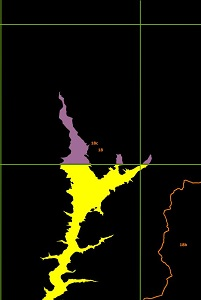

In [77]:
from IPython.display import Image,display
Image(filename='./quadBoundary.jpg')

In [41]:
pts = gpd.read_file('./weirdLakeBoundaries.shp')
lks = gpd.read_file('./AllNHDLakes.shp')

## Quad Boundaries^

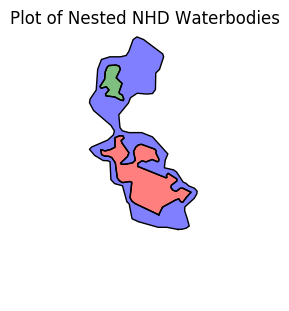

In [69]:
fig, ax = plt.subplots(1, figsize=(1.75,3))
base = lks.ix[lks.COMID == 20291137].plot(ax=ax, color='blue')
base2 = lks.ix[lks.COMID == 20291141].plot(ax=base, color='red')
lks.ix[lks.COMID == 20291139].plot(ax=base2, color='green')
ax.axis('off')
ax.set_title("Plot of Nested NHD Waterbodies")

### Table of lakes plotted above

In [50]:
lks.ix[lks.COMID.isin([20291141,20291137,20291139])]

,AREASQKM,COMID,ELEVATION,FCODE,FDATE,FTYPE,GNIS_ID,GNIS_NAME,REACHCODE,RESOLUTION,SHAPE_AREA,SHAPE_LENG,geometry
1930,0.520,20291137,0.0,39001,1999-07-16,LakePond,None,None,18080003001784,Medium,0.000055,0.104608,POLYGON ((-121.0136019892694 40.52790887042596...
1931,0.221,20291141,0.0,39004,1999-07-16,LakePond,260068,Feather Lake,18080003001914,Medium,0.000024,0.037254,POLYGON ((-121.0155785225996 40.52916900375732...
1936,0.039,20291139,0.0,39004,2009-12-01,LakePond,None,None,18080003009986,Medium,0.000004,0.010479,POLYGON ((-121.0192499892606 40.53900867040869...


### Also worth mentioning...There are a number of cases where lakes share just one point in common as seen below. Should this be possible??

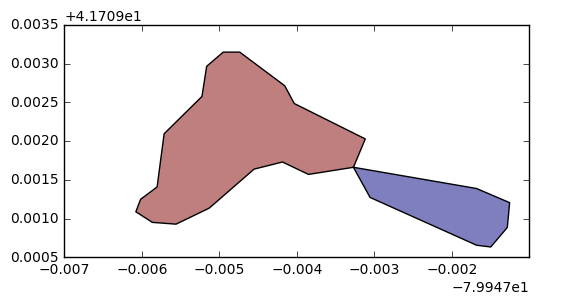

In [82]:
lks.ix[lks.COMID.isin([15445355,9049529])].plot()

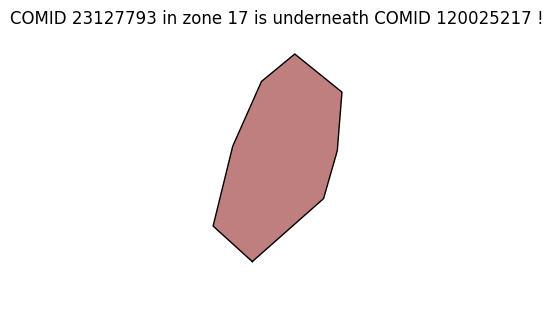

In [74]:
fig, ax = plt.subplots(1, figsize=(1.75,3.))
lks.ix[lks.COMID.isin([23127793])].plot(ax=ax)
ax.axis('off')
ax.set_title("COMID 23127793 in zone 17 is underneath COMID 120025217 !")

__PS: The name of the COMID attribute field is labelled 'ComID' (not all caps) in zones 03N, 03S, 03W, 13, 14, 15, 16 ----__

In [37]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b><a href="javascript:code_toggle()">:)</a></b>''')